In [1]:
cd ..

/home/dmitriishubin/Desktop/Projects/fraud_detection/modeling


In [2]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,mean_absolute_error,roc_curve, auc

from utils.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

# Field for global variables

In [3]:
DATA_PATH = './data/processed/'


FEATURES = pd.read_csv('./experiments/pat_optimized/features.csv')['0'].to_list()
files = [i for i in os.listdir(DATA_PATH) if i.find('test')!=-1]

MODEL_PATH = './experiments/pat_optimized/1_lgb_model.pkl'

# Load the data

In [4]:
for index,file in enumerate(files):
    
    if index == 0:
        df = pd.read_csv(DATA_PATH+file)
    else:
        temp = pd.read_csv(DATA_PATH+file)
        df = df.append(temp)

df = df.sort_values(by='Time')
df.head(5)

,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,diff
0,0.155163,-0.525324,-1.351103,-1.509281,-1.752188,0.154121,0.228898,0.173046,-1.608903,-0.431852,...,-0.259471,1.128948,-0.563144,-0.543998,-0.661309,-0.096865,0.141882,457.75,0,0.0
1,-1.400610,-0.553617,0.587429,-2.054100,1.297219,0.206195,-1.173674,-0.167376,0.383199,-0.839710,...,-0.493142,0.006889,-0.467570,-0.475793,0.150138,0.248055,0.082857,0.89,0,0.0
2,-1.163984,-0.949218,0.132920,-1.706721,-1.703319,1.253259,-1.381618,-0.623965,0.134451,0.313022,...,0.954231,-1.257424,0.148638,-0.313752,0.008125,0.767950,0.286614,449.00,0,0.0
3,2.039643,0.043199,-1.025568,1.074061,0.434267,-0.137383,0.598104,0.168523,-1.398415,0.608995,...,1.162670,0.184397,-1.427015,0.074987,-0.321280,0.077166,0.128592,156.52,0,0.0
4,0.024917,0.816784,0.152776,-0.805624,0.712848,0.891667,-0.305852,-0.253502,0.497687,0.815087,...,-0.754206,0.179094,0.647749,-0.400432,0.095237,0.201899,0.069591,9.99,0,1.0


# Get predictions

In [5]:
model = pickle.load(open(MODEL_PATH, 'rb'))


labels = df['Class'].values

df = df[FEATURES].values

preds = model.predict(df,raw_score=True)
preds = 1 / (1 + np.exp(-1 * preds))
preds_hard = np.zeros(preds.shape)
preds_hard[preds >= 0.5] = 1

# F1 macro

In [6]:
print(f"F1 total: {f1_score(labels,preds_hard,labels=[0,1],average='macro')}")

F1 total: 0.6629882978121997


# F1 for each class

In [7]:
n_classes = 2

labels_oh = np.eye(n_classes)[labels.astype(np.int32)]
preds_oh = np.eye(n_classes)[preds_hard.astype(np.int32)]

for cl in range(n_classes):
    y_temp = labels_oh[:,cl]
    pred_temp = preds_oh[:,cl]
    
    print(f"Class: {cl}, F1 score: {f1_score(y_temp,pred_temp)}")
    print(f"Class: {cl}, balance: {np.mean(y_temp)}")

Class: 0, F1 score: 0.9994459833795014
Class: 0, balance: 0.9991948200087227
Class: 1, F1 score: 0.32653061224489793
Class: 1, balance: 0.0008051799912772167


# Precision, Recall, ROC-AUC

In [8]:
print(f"Precision: {precision_score(labels,preds_hard,labels=[0,1],average='macro')}")
print(f"Recall: {recall_score(labels,preds_hard,labels=[0,1],average='macro')}")
print(f"ROC-AUC score: {roc_auc_score(labels_oh[:,1],preds)}")

Precision: 0.659731381371298
Recall: 0.6663812689565636
ROC-AUC score: 0.8294370949870732


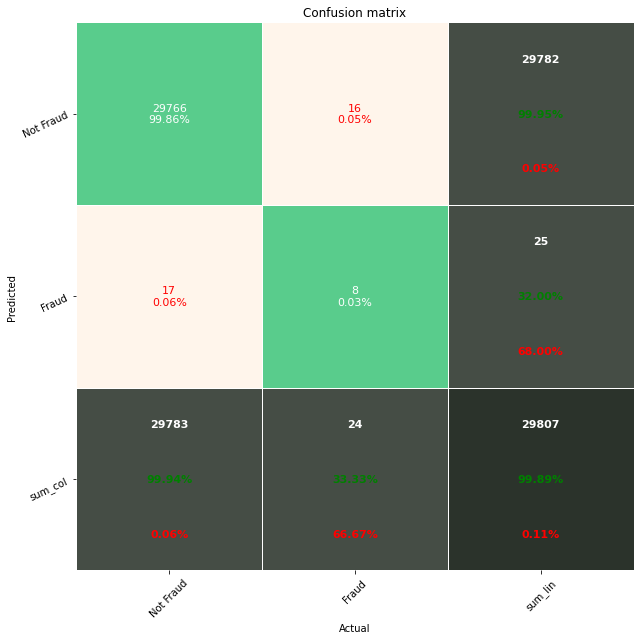

In [9]:
plot_confusion_matrix_from_data(labels,preds_hard,columns=['Not Fraud','Fraud'])

# ROC-AUC curve

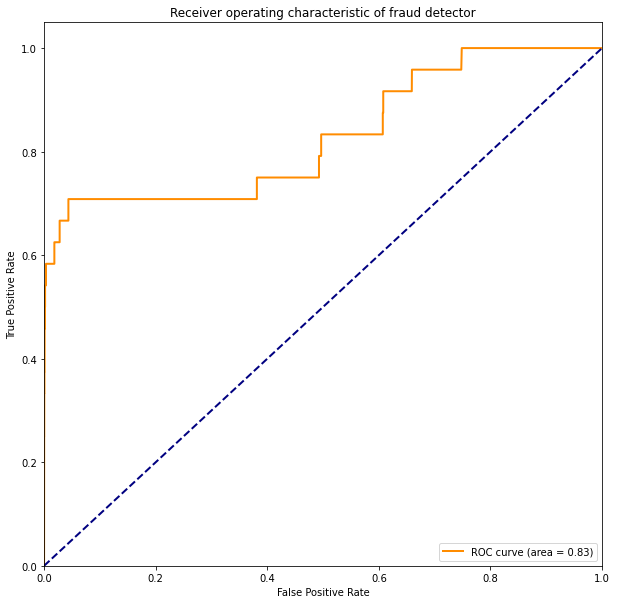

In [10]:
fpr, tpr, _ = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of fraud detector")
plt.legend(loc="lower right")
plt.show()